# Приложение доставки

## Общие положения:

В приложение по доставке продуктов внедрили умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В `группе 1` оказались пользователи с `новой` системой рекомендаций, в `группе 0` пользователи со `старой` версией приложения, где нет рекомендации товаров.

## Цель:

Оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

## Описание таблиц:
 - `users` – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
 - `orders` – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
 - `products` – подробная информация о продуктах, их название и стоимость

## Задачи:

1. **Проведем небольшой препроцессинг**
    - Подключим необходимые библиотеки
    - Загрузим и изучим имеющиеся данные
2. **Сформулируем и протестируем гипотезу:**
    - Определим ключевые метрики
    - Построим графики
    - Выберем подходящую гипотезу и тест
    - Проведем тест
3. **Подведем итоги:**
    - Сформулируем выводы

## 1)Загружаем и изучаем данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import urllib
import json
import re

%matplotlib inline

In [2]:
def get_href(folder_url):
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key=' + urllib.parse.quote(folder_url)
    r = requests.get(url) # запрос ссылки на скачивание 
    return json.loads(r.text)['href'] # 'парсинг' ссылки на скачивание

In [3]:
def rename_group(name):
    if name == 0:
        return 'control'
    elif name == 1:
        return 'test'

In [4]:
sns.set(
    font_scale =2,
    style      ='whitegrid',
    rc         ={'figure.figsize':(12, 8)}
)

In [5]:
users = pd.read_csv(get_href('https://disk.yandex.ru/d/4qY27tJ23G_B1g'), parse_dates=['time', 'date'], error_bad_lines=False)

In [6]:
orders = pd.read_csv(get_href('https://disk.yandex.ru/d/prdO8FDQx7lzCg'), parse_dates=['creation_time'], error_bad_lines=False)

In [7]:
products = pd.read_csv(get_href('https://disk.yandex.ru/d/atwrlmB_wu-fHA'), error_bad_lines=False)

In [8]:
users.group = users.group.apply(rename_group)

Для удобства изменим название групп, `где 0 - control`, `1 - test`.

In [9]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,control
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,control
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,test


In [10]:
users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [11]:
users.action.value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

In [12]:
users.loc[users.group == 'control'].action.value_counts()

create_order    1609
cancel_order      82
Name: action, dtype: int64

In [13]:
users.loc[users.group == 'test'].action.value_counts()

create_order    2514
cancel_order     132
Name: action, dtype: int64

In [14]:
(round(132 / 82, 2) - 1) * 100

61.00000000000001

#### Отмененных заказов в тестовой группе больше на 61%

In [15]:
users.shape

(4337, 6)

In [16]:
users.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [17]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [18]:
orders.shape

(4123, 3)

In [19]:
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [20]:
orders.creation_time.min()

Timestamp('2022-08-26 00:00:19')

In [21]:
orders.creation_time.max()

Timestamp('2022-09-08 23:41:24')

In [22]:
orders.creation_time.max() - orders.creation_time.min()

Timedelta('13 days 23:41:05')

#### В таблице orders представлены данные за 14 дней с 2022-08-26 по 2022-09-08

In [23]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [24]:
products.shape

(87, 3)

In [25]:
products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

#### Пропусков в данных нет. В таблице имеются отмененные заказы, в дальнейшем, мы не будем их учитывать. Другие аномалии, на первый взгляд, так же отсутствуют.

Разобьем таблицу заказов по колонке продуктов, чтобы объединить таблицы и посчитать стоимость каждого заказа.

In [26]:
canceled_id = users.loc[users.action == 'cancel_order'].order_id

In [27]:
users = users.query("order_id not in @canceled_id")

In [28]:
orders.product_ids = orders.product_ids.apply(lambda x: re.sub('[{}]', '', x).split(', '))

In [29]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"[74, 6]"
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [30]:
exploded_orders = orders.explode('product_ids')

In [31]:
exploded_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56


In [32]:
exploded_orders.rename(columns={'product_ids': 'product_id'}, inplace=True)

In [33]:
products.product_id = products.product_id.astype(int)
exploded_orders.product_id = exploded_orders.product_id.astype(int)

In [34]:
exploded_orders.shape[0]

13826

In [35]:
merged_orders = exploded_orders.merge(products, on='product_id')

In [36]:
merged_orders.head()

,order_id,creation_time,product_id,name,price
0,1255,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,1287,2022-08-26 00:31:36,75,сок ананасовый,120.0
2,1403,2022-08-26 03:01:40,75,сок ананасовый,120.0
3,1424,2022-08-26 04:01:22,75,сок ананасовый,120.0
4,1495,2022-08-26 06:04:05,75,сок ананасовый,120.0


In [37]:
full_data = users.merge(merged_orders, on='order_id')

In [38]:
full_data.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,control,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,test,2022-08-26 00:02:21,56,сосиски,150.0


На данном этапе все таблицы объединены и 

## 2)Сформулируем и протестируем гипотезу

In [39]:
count_users = full_data.groupby('group', as_index=False).agg({'user_id': 'nunique'})

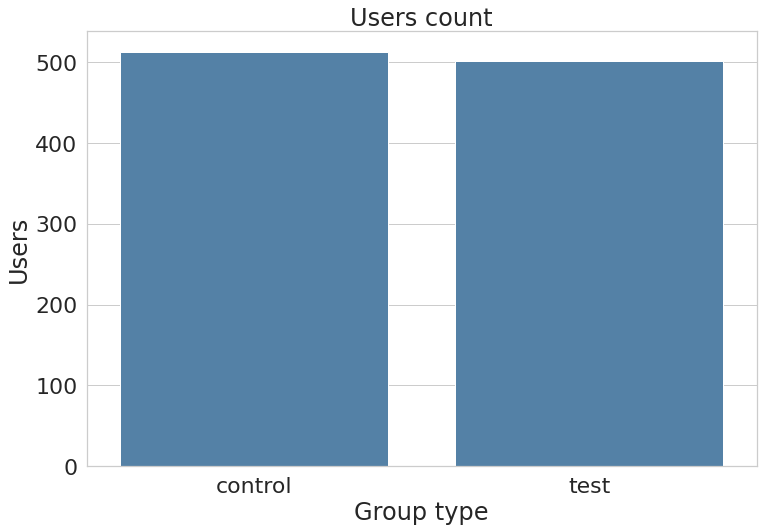

In [40]:
ax = sns.barplot(data=count_users, x='group', y='user_id', color='steelblue')
ax.set(xlabel='Group type', ylabel='Users', title='Users count')
plt.show()

In [41]:
count_orders = full_data.groupby('group', as_index=False).agg({'order_id': 'nunique'})

#### Размеры контрольной и тестовой группы почти не отличаются.

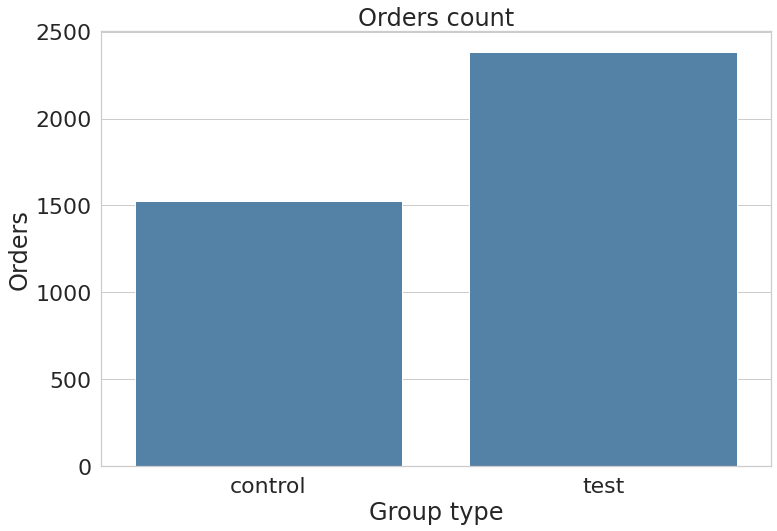

In [42]:
ax = sns.barplot(data=count_orders, x='group', y='order_id', color='steelblue')
ax.set(xlabel='Group type', ylabel='Orders', title='Orders count')
plt.show()

#### Тестовая группа превосходит контрольную по количеству заказов.

In [43]:
earned_money = full_data.groupby('group', as_index=False).agg({'price': 'sum'})

In [44]:
earned_money

,group,price
0,control,583455.9
1,test,878628.4


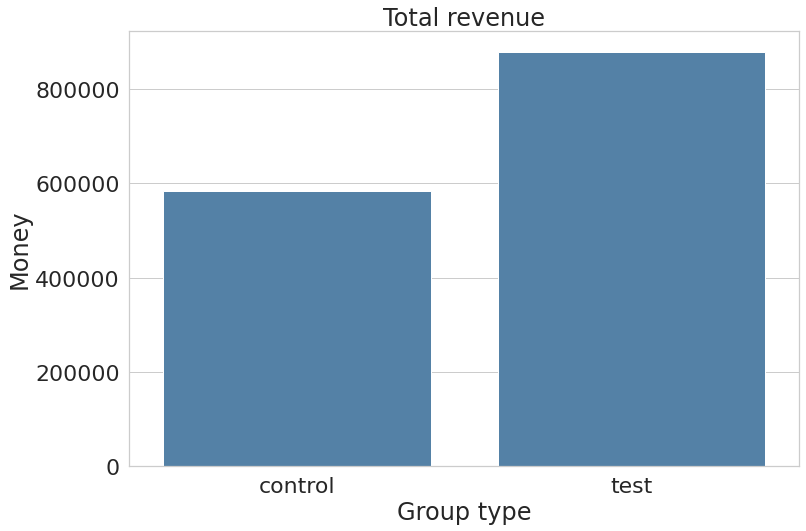

In [45]:
ax = sns.barplot(data=earned_money, x='group', y='price', color='steelblue')
ax.set_yticklabels(['{}'.format(int(n)) for n in ax.get_yticks()])
ax.set(xlabel='Group type', ylabel='Money', title='Total revenue')
plt.show()

#### Тестовая группа так же принесла значительно большую прибыль по сравнению с контрольной.